# Regression with Outliers

In the standard __Gaussian process regression__ setting it is assumed that the observations are __Normally distributed__ about the latent function. In the package this can applied using either the `GP` or `GPE` functions with which *exact Gaussian process* models.

One of the drawbacks of exact GP regression is that by assuming Normal noise the GP is __not robust to outliers__. In this setting, it is more appropriate to assume that the distribution of the noise is heavy tailed. For example, with a __Student-t distribution__,
$$
\mathbf{y} \ | \ \mathbf{f},\nu,\sigma \sim \prod_{i=1}^n \frac{\Gamma(\nu+1)/2}{\Gamma(\nu/2)\sqrt{\nu\pi}\sigma}\left(1+\frac{(y_i-f_i)^2}{\nu\sigma^2}\right)^{-(\nu+1)/2}
$$

Moving away from the Gaussian likelihood function (i.e. Normally distributed noise) and using the Student-t likelihood means that we can no longer analytically calculate the GP marginal likelihood. We can take a Bayesian perspective and sample from the joint distribution of the latent function and model parameters.

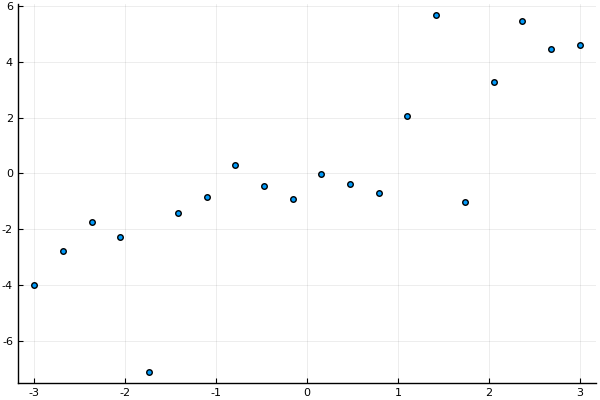

In [6]:
#Load functions from packages
using GaussianProcesses, Plots
using Distributions:Normal, TDist
using Random
using Statistics

#Simulate the data
Random.seed!(112233)
n = 20
X = range(-3,stop=3,length=n);
sigma = 1.0
Y = X + sigma*rand(TDist(3),n);

# Plots observations
pyplot()
scatter(X,Y;fmt=:png, leg=false)

We fit a standard (exact) Gaussian process model to the Student-t data and compare this against the Monte Carlo GP which is applicable for non-Gaussian observations models.

In [7]:
#Build the models

gpe = GPE(X,vec(Y),MeanZero(),Matern(3/2,0.0,0.0),0.5) #Exact GP assuming Gaussian noise

l = StuTLik(3,0.1)
gpa = GPA(X, vec(Y), MeanZero(), Matern(3/2,0.0,0.0), l) #Approximate GP with student-t likelihood

GP Approximate object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Iso{Float64}, Params: [0.0, 0.0]
  Likelihood:
    Type: StuTLik, Params: [0.1]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [-3.98707, -2.7855, -1.74722, -2.27384, -7.12662, -1.43191, -0.840899, 0.305618, -0.444213, -0.924319, -0.0303161, -0.368707, -0.706642, 2.07517, 5.68693, -1.02634, 3.25863, 5.46091, 4.45861, 4.60741]
  Log-posterior = -77.863

Estimate the parameters of the exact GP through maximum likelihood estimation

In [8]:
optimize!(gpe)

 * Status: success

 * Candidate solution
    Minimizer: [6.57e-01, 1.71e+00, 1.41e+00]
    Minimum:   4.578633e+01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [5.00e-01, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 2.08e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.21e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.10e-16 ≰ 0.0e+00
    |g(x)|                 = 4.69e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    13
    f(x) calls:    38
    ∇f(x) calls:   38


Taking a Bayesian perspective, we can add prior distributions to the model parameters and sample from the posterior distribution using Markov chain Monte Carlo through the `mcmc` function which uses a Hamiltonian Monte Carlo sampler.

In [9]:
set_priors!(gpa.lik,[Normal(-2.0,4.0)])
set_priors!(gpa.kernel,[Normal(-2.0,4.0),Normal(-2.0,4.0)])

samples = mcmc(gpa;nIter=10000,burn=1000,thin=2);

Number of iterations = 10000, Thinning = 2, Burn-in = 1000 
Step size = 0.100000, Average number of leapfrog steps = 10.015000 
Number of function calls: 100151
Acceptance rate: 0.461500 


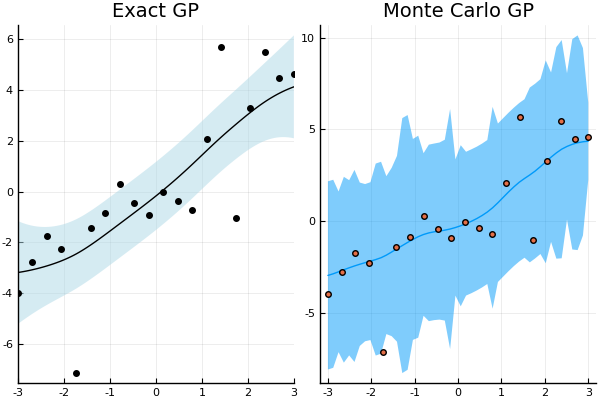

In [10]:
#Plot posterior samples
xtest = range(minimum(gpa.x),stop=maximum(gpa.x),length=50);

#Set the parameters to the posterior values the sample random function
fsamples = [];
for i in 1:size(samples,2)
    set_params!(gpa,samples[:,i])
    update_target!(gpa)
    push!(fsamples, rand(gpa,xtest))
end

#Predict
p1=plot(gpe,leg=false, title="Exact GP")   #Exact GP (assuming Gaussian noise)


sd = [std(fsamples[i]) for i in 1:50]
p2=plot(xtest,mean(fsamples),ribbon=2*sd,leg=false, title="Monte Carlo GP") #GP Monte Carlo with student-t noise
scatter!(X,Y)

plot(p1,p2;fmt=:png)